# ERA5 Geometric Altitude

For the MCS env cond paper, reviewer #3 has asked for a new variable to be added: ECAPE. This requires a vertical height coord, geometric altitude, as an input. This is not as straightforward as you might have though because geometric altitude is not a coordinate of IFS/ERA5 [IFS Documentation CY41R2][1]. Instead, it uses a hybrid height coord based on the surface pressure [IFS Documentation CY41R2][1]. The geopotential is readily available, but converting between this and geometric altitude requires a procedure described here [ERA5: compute pressure and geopotential on model levels, geopotential height and geometric height][2]. Essentially, this boils down to integrating up the hypsometric equation to convert geopotential on the surface to geopotential at each model level. Then this can be converted to geopotential height, and then geometric altitude. Here is the procedure:

1. Take as inputs: lnsp (natural log of surface pressure, units `log(Pa)`?), zsfc (surface geopotential, units `m**2 s**-2`), T on model levels (`K`), q on model levels (`kg kg**-1`).
2. From lnsp, calculate p on model levels following: https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height#ERA5:computepressureandgeopotentialonmodellevels,geopotentialheightandgeometricheight-Pressureonmodellevels
3. From zsfc, calculate z (geopotential) on model levels following https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height#ERA5:computepressureandgeopotentialonmodellevels,geopotentialheightandgeometricheight-Geopotentialonmodellevels
   1. This works by integrating up the hypsometric equation (for z)
   2. z_h (z on half levels) is known - z at previous model level (starting from zsfc)
   3. Calculate Tv (or as its better named, density pressure, Trho - here stick with customary Tv): $T_v = T[1 + (\frac{R_v}{R_d} - 1)q]$ \
      TODO: extra factor of Rd?
   4. Calculate `dlog_p = np.log(ph_levplusone / ph_lev)`
   5. Calculate `alpha = 1. - ((ph_lev / (ph_levplusone - ph_lev)) * dlog_p)` (interp. scaling)
   6. Calc z_f (z on full levels): `z_f = z_h + (Tv[lev_idx] * alpha)`
   7. Calc new z_h: `z_h = z_h + (Tv[lev_idx] * dlog_p)`. Can now move up to next level.
   8. (Notes) ERA5 sfc level is 137, top is 1. \
      Getting curr/next level is easy to mess up
      Conditional to handle model level 1.
4. Once z on all model levels known, convert to geopotential height, `h = z / g`
5. Convert h to geometric altitude, `alt = Re * h / (Re - h)`

There is a script provided for downloading grib data of lnsp/zsfc, T/q, and another for using these to calc z on all model levels. I also have access to all of the required variables on `/badc/ecmwf-era5/data/oper/` in .nc format. The purpose of this notebook is to compare the two methods and make sure the answers are close enough/comparable.

[1]: https://www.ecmwf.int/en/elibrary/79696-ifs-documentation-cy41r2-part-iii-dynamics-and-numerical-procedures
[2]: https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height

In [1]:
# Orig code in /home/users/mmuetz/projects/mcs_prime/experimental/era5_altitude
# Do as notebook.
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from IPython.display import clear_output

# Contains previous code for calculating pressure from lnsp.
from mcs_prime.era5_calc import ERA5Calc

/home/users/mmuetz/projects/mcs_prime/mcs_prime/mcs_prime_config_util.py:69: UserWarning: Warning: path missing era5dir: /does/not/exist
  warnings.warn(f"Warning: path missing {k}: {path}")


In [2]:
Rd = 287.06
g = 9.80665
# As used by IFS: https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-SpatialreferencesystemsandEarthmodel
Re = 6371229 # m

In [3]:
def convert_da_lon_0to360_n180to180(da):
    """Modifies DataArray in place"""
    lon = da.longitude
    # Note I want to convert +180 to -180 and start lon with this value (to match GRIB).
    roll_idx = -np.where(lon >= 180)[0][0]
    new_lon = np.roll(np.where(lon < 180, lon, lon - 360), roll_idx)
    assert -180 <= new_lon.min()
    assert 180 >= new_lon.max()
    dx = np.diff(new_lon)
    assert np.all(dx >= 0)

    da.coords['longitude'] = new_lon
    da.values = np.roll(da.values, roll_idx, axis=-1)

if False:
    # Test that this works for a 3D var (T).
    basepath = '/badc/ecmwf-era5/data/oper/an_ml/2020/01/01/'
    
    # da: 0 to 360
    # da2: -180 to 180
    da = xr.load_dataarray(basepath + 'ecmwf-era5_oper_an_ml_202001010000.t.nc')[0].sel(latitude=slice(60, -60))
    da2 = da.copy()
    convert_da_lon_0to360_n180to180(da2)
    
    assert (da.sel(longitude=0).values == da2.sel(longitude=0).values).all()
    assert (da.sel(longitude=10).values == da2.sel(longitude=10).values).all()
    assert (da.sel(longitude=350).values == da2.sel(longitude=-10).values).all()


## Load/compute alt for netcdf data (2020-01-01 0000Z)

In [4]:
  
class NCComputeAlt:
    """Compute geopotential (z) from netcdf data, then compute altitude (alt)
    
    Code taken from existing code for doing the same for GRIB data"""
    def __init__(self):
        self.e5calc = ERA5Calc('/gws/nopw/j04/mcs_prime/mmuetz/data/ERA5/ERA5_L137_model_levels_table.csv')

    def load(self):
        basepath = '/badc/ecmwf-era5/data/oper/an_ml/2020/01/01/'

        # xr.DataArray. Restrict to same domain as GRIB (60N to 60S).
        self.daT = xr.load_dataarray(basepath + 'ecmwf-era5_oper_an_ml_202001010000.t.nc')[0].sel(latitude=slice(60, -60))
        self.daq = xr.load_dataarray(basepath + 'ecmwf-era5_oper_an_ml_202001010000.q.nc')[0].sel(latitude=slice(60, -60))
        self.dazsfc = xr.load_dataarray(basepath + 'ecmwf-era5_oper_an_ml_202001010000.z.nc')[0].sel(latitude=slice(60, -60))
        self.dalnsp = xr.load_dataarray(basepath + 'ecmwf-era5_oper_an_ml_202001010000.lnsp.nc')[0].sel(latitude=slice(60, -60))

        # Convert from lon: 0 to 360 to -180 to 180 for easier comparison with GRIB.
        for da in [self.daT, self.daq, self.dazsfc, self.dalnsp]:
            convert_da_lon_0to360_n180to180(da)

        # np.array
        self.p = self.e5calc.calc_pressure(self.dalnsp.values)

    def run(self):
        T = self.daT.values
        q = self.daq.values
        p = self.p
        zsfc = self.dazsfc.values
        # Get levels in ascending order of height (starts at 137)
        levels = self.daT.level.values[::-1]
        # print(levels)

        # 0.609133 = Rv/Rd - 1.
        # TODO: Why extra RD
        Tv = T * (1. + 0.609133 * q) * Rd
        z_h = zsfc

        z = np.zeros_like(p)
        for lev in levels:
            lev_idx = lev - 1
            # print(lev, lev_idx)
            z_h, z_f = self.compute_z_level(lev_idx, p, Tv, z_h)
            z[lev_idx] = z_f

        h = z / g
        alt = Re * h / (Re - h)

        self.z = z
        self.h = h
        self.alt = alt
        return z, h, alt

    def compute_z_level(self, lev_idx, p, Tv, z_h):
        '''Compute z at half & full level for the given level, based on T/q/sp'''
        # compute the pressures (on half-levels)
        # ph_lev, ph_levplusone = get_ph_levs(values, lev)
        ph_lev, ph_levplusone = p[lev_idx - 1], p[lev_idx]
    
        if lev_idx == 0:
            dlog_p = np.log(ph_levplusone / 0.1)
            alpha = np.log(2)
        else:
            dlog_p = np.log(ph_levplusone / ph_lev)
            alpha = 1. - ((ph_lev / (ph_levplusone - ph_lev)) * dlog_p)
    
        # z_f is the geopotential of this full level
        # integrate from previous (lower) half-level z_h to the
        # full level
        z_f = z_h + (Tv[lev_idx] * alpha)
    
        # z_h is the geopotential of 'half-levels'
        # integrate z_h to next half level
        z_h = z_h + (Tv[lev_idx] * dlog_p)
    
        return z_h, z_f

In [5]:
nc_comp_alt = NCComputeAlt()
nc_comp_alt.load()
z1, h1, alt1 = nc_comp_alt.run()
z1.shape, h1.shape, alt1.shape

((137, 481, 1440), (137, 481, 1440), (137, 481, 1440))

## Download/load/compute alt for grib data (2020-01-01 0000Z)

* Only download as necessary
* Uses `compute_geopotential_on_ml.py` from https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height#ERA5:computepressureandgeopotentialonmodellevels,geopotentialheightandgeometricheight-Step2:Computegeopotentialonmodellevels
* Stores z on ml result as GRIB (as necessary again)
* Compute alt just loads z on ml and does basic computation

In [6]:
# The same as on https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height#ERA5:computepressureandgeopotentialonmodellevels,geopotentialheightandgeometricheight-Geopotentialonmodellevels
# But modified to get data for 2020-01-01, and only download data if not already there.

from pathlib import Path

tq_ml_path = Path('data/tq_ml.grib')
zlnsp_path = Path('data/zlnsp_ml.grib')


def download_grib_data():
    #!/usr/bin/env python

    Path('data').mkdir(exist_ok=True)
    
    # data download specifications:
    cls     = "ea"         # do not change
    expver  = "1"          # do not change
    levtype = "ml"         # do not change
    stream  = "oper"       # do not change
    date    = "2020-01-01" # date: Specify a single date as "2018-01-01" or a period as "2018-08-01/to/2018-01-31". For periods > 1 month see https://confluence.ecmwf.int/x/l7GqB
    tp      = "an"         # type: Use "an" (analysis) unless you have a particular reason to use "fc" (forecast).
    time    = "00:00:00"   # time: ERA5 data is hourly. Specify a single time as "00:00:00", or a range as "00:00:00/01:00:00/02:00:00" or "00:00:00/to/23:00:00/by/1".

    if not tq_ml_path.exists():
        # Put import here because it enables debug.
        import cdsapi
        c = cdsapi.Client()

        c.retrieve('reanalysis-era5-complete', {
            'class'   : cls,
            'date'    : date,
            'expver'  : expver,
            'levelist': '1/2/3/4/5/6/7/8/9/10/11/12/13/14/15/16/17/18/19/20/21/22/23/24/25/26/27/28/29/30/31/32/33/34/35/36/37/38/39/40/41/42/43/44/45/46/47/48/49/50/51/52/53/54/55/56/57/58/59/60/61/62/63/64/65/66/67/68/69/70/71/72/73/74/75/76/77/78/79/80/81/82/83/84/85/86/87/88/89/90/91/92/93/94/95/96/97/98/99/100/101/102/103/104/105/106/107/108/109/110/111/112/113/114/115/116/117/118/119/120/121/122/123/124/125/126/127/128/129/130/131/132/133/134/135/136/137',         # For each of the 137 model levels
            'levtype' : 'ml',
            'param'   : '130/133', # Temperature (t) and specific humidity (q)
            'stream'  : stream,
            'time'    : time,
            'type'    : tp,
            'grid'    : [0.25, 0.25], # Latitude/longitude grid: east-west (longitude) and north-south resolution (latitude). Default: 0.25 x 0.25
            'area'    : [60, -180, -60, 180], #example: [60, -10, 50, 2], # North, West, South, East. Default: global
        }, str(tq_ml_path))
    
    if not zlnsp_path.exists():
        # Put import here because it enables debug.
        import cdsapi
        c = cdsapi.Client()
        
        c.retrieve('reanalysis-era5-complete', {
            'class'   : cls,
            'date'    : date,
            'expver'  : expver,
            'levelist': '1',       # Geopotential (z) and Logarithm of surface pressure (lnsp) are 2D fields, archived as model level 1
            'levtype' : levtype,
            'param'   : '129/152', # Geopotential (z) and Logarithm of surface pressure (lnsp)
            'stream'  : stream,
            'time'    : time,
            'type'    : tp,
            'grid'    : [0.25, 0.25], # Latitude/longitude grid: east-west (longitude) and north-south resolution (latitude). Default: 0.25 x 0.25
            'area'    : [60, -180, -60, 180], #example: [60, -10, 50, 2], # North, West, South, East. Default: global
        }, str(zlnsp_path))
        
download_grib_data()

In [7]:
from eccodes import (codes_index_new_from_file, codes_index_get, codes_get,
                     codes_index_select, codes_new_from_index, codes_set,
                     codes_index_add_file, codes_get_array, codes_get_values,
                     codes_index_release, codes_release, codes_set_values,
                     codes_write)
 
R_D = 287.06
R_G = 9.80665
 
zout_path = Path('data/z_out.grib')

def main():
    '''Main function'''
    if zout_path.exists():
        print(f'{zout_path} already exists')
        return
        
    class Args(object):
        def __contains__(self, key):
            return key in self.__dict__
    
    args = Args()
    args.output = str(zout_path)
    args.z_lnsp = str(zlnsp_path)
    args.t_q = str(tq_ml_path)
    args.levelist = range(1, 138) 
    
    print('Arguments: %s' % ", ".join(
        ['%s: %s' % (k, v) for k, v in vars(args).items()]))
 
    fout = open(args.output, 'wb')
    index_keys = ['date', 'time', 'shortName', 'level', 'step']
 
    idx = codes_index_new_from_file(args.z_lnsp, index_keys)
    codes_index_add_file(idx, args.t_q)

    values = None
    # iterate date
    for date in codes_index_get(idx, 'date'):
        codes_index_select(idx, 'date', date)
        # iterate time
        for time in codes_index_get(idx, 'time'):
            codes_index_select(idx, 'time', time)
            for step in codes_index_get(idx, 'step'):
                codes_index_select(idx, 'step', step)
                if not values:
                    values = get_initial_values(idx, keep_sample=True)
                if 'height' in args:
                    values['height'] = args.height
                    values['gh'] = args.height * R_G + values['z']
                if 'levelist' in args:
                    values['levelist'] = args.levelist
                    # surface pressure
                    try:
                        values['sp'] = get_surface_pressure(idx)
                        production_step(idx, step, values, fout)
                    except WrongStepError:
                        if step != '0':
                            raise
 
        try:
            codes_release(values['sample'])
        except KeyError:
            pass
 
    codes_index_release(idx)
    fout.close()
 
 
def get_initial_values(idx, keep_sample=False):
    '''Get the values of surface z, pv and number of levels '''
    codes_index_select(idx, 'level', 1)
    codes_index_select(idx, 'shortName', 'z')
    gid = codes_new_from_index(idx)
 
    values = {}
    # surface geopotential
    values['z'] = codes_get_values(gid)
    values['pv'] = codes_get_array(gid, 'pv')
    values['nlevels'] = codes_get(gid, 'NV', int) // 2 - 1
    check_max_level(idx, values)
    if keep_sample:
        values['sample'] = gid
    else:
        codes_release(gid)
    return values
 
 
def check_max_level(idx, values):
    '''Make sure we have all the levels required'''
    # how many levels are we computing?
    max_level = max(codes_index_get(idx, 'level', int))
    if max_level != values['nlevels']:
        print('%s [WARN] total levels should be: %d but it is %d' %
              (sys.argv[0], values['nlevels'], max_level),
              file=sys.stderr)
        values['nlevels'] = max_level
 
 
def get_surface_pressure(idx):
    '''Get the surface pressure for date-time-step'''
    codes_index_select(idx, 'level', 1)
    codes_index_select(idx, 'shortName', 'lnsp')
    gid = codes_new_from_index(idx)
    if gid is None:
        raise WrongStepError()
    if codes_get(gid, 'gridType', str) == 'sh':
        print('%s [ERROR] fields must be gridded, not spectral' % sys.argv[0],
              file=sys.stderr)
        sys.exit(1)
    # surface pressure
    sfc_p = np.exp(codes_get_values(gid))
    codes_release(gid)
    return sfc_p
 
 
def get_ph_levs(values, level):
    '''Return the presure at a given level and the next'''
    a_coef = values['pv'][0:values['nlevels'] + 1]
    b_coef = values['pv'][values['nlevels'] + 1:]
    ph_lev = a_coef[level - 1] + (b_coef[level - 1] * values['sp'])
    ph_levplusone = a_coef[level] + (b_coef[level] * values['sp'])
    return ph_lev, ph_levplusone
 
 
def compute_z_level(idx, lev, values, z_h):
    '''Compute z at half & full level for the given level, based on t/q/sp'''
    # select the levelist and retrieve the vaules of t and q
    # t_level: values for t
    # q_level: values for q
    codes_index_select(idx, 'level', lev)
    codes_index_select(idx, 'shortName', 't')
    gid = codes_new_from_index(idx)
    if gid is None:
        raise MissingLevelError('T at level {} missing from input'.format(lev))
    t_level = codes_get_values(gid)
    codes_release(gid)
    codes_index_select(idx, 'shortName', 'q')
    gid = codes_new_from_index(idx)
    if gid is None:
        raise MissingLevelError('Q at level {} missing from input'.format(lev))
    q_level = codes_get_values(gid)
    codes_release(gid)
 
    # compute moist temperature
    t_level = t_level * (1. + 0.609133 * q_level)
 
    # compute the pressures (on half-levels)
    ph_lev, ph_levplusone = get_ph_levs(values, lev)
 
    if lev == 1:
        dlog_p = np.log(ph_levplusone / 0.1)
        alpha = np.log(2)
    else:
        dlog_p = np.log(ph_levplusone / ph_lev)
        alpha = 1. - ((ph_lev / (ph_levplusone - ph_lev)) * dlog_p)
 
    t_level = t_level * R_D
 
    # z_f is the geopotential of this full level
    # integrate from previous (lower) half-level z_h to the
    # full level
    z_f = z_h + (t_level * alpha)
 
    # z_h is the geopotential of 'half-levels'
    # integrate z_h to next half level
    z_h = z_h + (t_level * dlog_p)
 
    return z_h, z_f
 
 
def production_step(idx, step, values, fout):
    '''Compute z at half & full level for the given level, based on t/q/sp'''
    # We want to integrate up into the atmosphere, starting at the
    # ground so we start at the lowest level (highest number) and
    # keep accumulating the height as we go.
    # See the IFS documentation, part III
    # For speed and file I/O, we perform the computations with
    # numpy vectors instead of fieldsets.
 
    z_h = values['z']
    codes_set(values['sample'], 'step', int(step))
 
    for lev in sorted(values['levelist'], reverse=True):
        try:
            z_h, z_f = compute_z_level(idx, lev, values, z_h)
            # store the result (z_f) in a field and add to the output
            codes_set(values['sample'], 'level', lev)
            codes_set_values(values['sample'], z_f)
            codes_write(values['sample'], fout)
        except MissingLevelError as e:
            print('%s [WARN] %s' % (sys.argv[0], e),
                  file=sys.stderr)
 
 
class WrongStepError(Exception):
    ''' Exception capturing wrong step'''
    pass
 
 
class MissingLevelError(Exception):
    ''' Exception capturing missing levels in input'''
    pass
 
main()

data/z_out.grib already exists


In [8]:
import cfgrib

class GRIBComputeAlt:
    def load(self):
        ds_zsfc_lnsp = xr.open_dataset(zlnsp_path, engine='cfgrib')
        ds_tq = xr.open_dataset(tq_ml_path, engine='cfgrib')
        self.dazsfc = ds_zsfc_lnsp.z
        self.dalnsp = ds_zsfc_lnsp.lnsp
        self.daT = ds_tq.t
        self.daq = ds_tq.q
        self.daz = xr.open_dataarray(zout_path, engine='cfgrib')

    def run(self):
        z = self.daz.values
        h = z / g
        alt = Re * h / (Re - h)

        self.z = z
        self.h = h
        self.alt = alt
        return z, h, alt
        

In [9]:
grib_comp_alt = GRIBComputeAlt()
grib_comp_alt.load()
z2, h2, alt2 = grib_comp_alt.run()

In [10]:
z1.shape, z2.shape

((137, 481, 1440), (137, 481, 1440))

# Compare the results from using netcdf/GRIB.

## Basic sanity checks 

In [33]:
# Check all coord values are the same.
# Note, netcdf stores the vert coord as level, grib as hybrid.
assert (nc_comp_alt.dalnsp.longitude.values == grib_comp_alt.dalnsp.longitude.values).all()
assert (nc_comp_alt.dalnsp.latitude.values == grib_comp_alt.dalnsp.latitude.values).all()
assert (nc_comp_alt.daT.level.values == grib_comp_alt.daT.hybrid.values).all()

In [15]:
import matplotlib.pyplot as plt


## Compare the fields by calculating absmax diff, RMSE and producing scatter plots

In [66]:
def rmse(a1, a2):
    return np.sqrt(((a1 - a2)**2).mean())


def compare_fields2D(da1, da2, fname):
    f1 = getattr(da1, fname).values
    f2 = getattr(da2, fname).values
    print(f'{fname}, absmax diff: {np.abs(f1 - f2).max()}, RMSE: {rmse(f1, f2)}')
    plt.figure()
    plt.title(fname)
    plt.xlabel(f'nc {fname}')
    plt.ylabel(f'grib {fname}')
    plt.scatter(f1, f2, marker='+')


def compare_fields3D(da1, da2, fname):
    f1 = getattr(da1, fname).values[-10:]
    f2 = getattr(da2, fname).values[-10:]
    print(f'{fname} (10 lowest levels), absmax diff: {np.abs(f1 - f2).max()}, RMSE: {rmse(f1, f2)}')
    plt.figure()
    plt.title(fname)
    plt.xlabel(f'nc {fname}')
    plt.ylabel(f'grib {fname}')
    plt.scatter(f1, f2, marker='+')

dalnsp, absmax diff: 5.7220458984375e-06, RMSE: 3.349039161548717e-06
dazsfc, absmax diff: 0.44921875, RMSE: 0.2664412260055542
daq (10 lowest levels), absmax diff: 6.444752216339111e-07, RMSE: 2.1697520935504144e-07
daT (10 lowest levels), absmax diff: 0.0030517578125, RMSE: 0.0010215785587206483


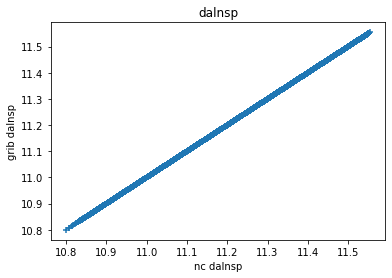

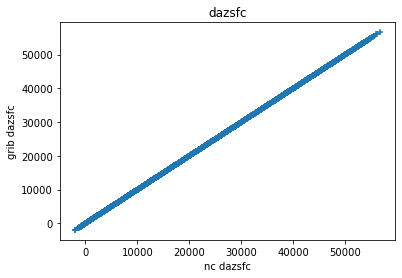

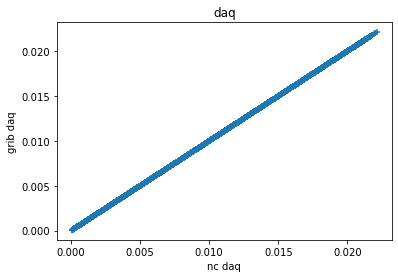

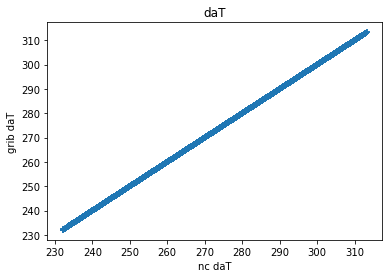

In [58]:
compare_fields2D(nc_comp_alt, grib_comp_alt, 'dalnsp')
compare_fields2D(nc_comp_alt, grib_comp_alt, 'dazsfc')
compare_fields3D(nc_comp_alt, grib_comp_alt, 'daT')
compare_fields3D(nc_comp_alt, grib_comp_alt, 'daq')

### Interpretation of field comparison

All are almost identical except for z sfc. Why?

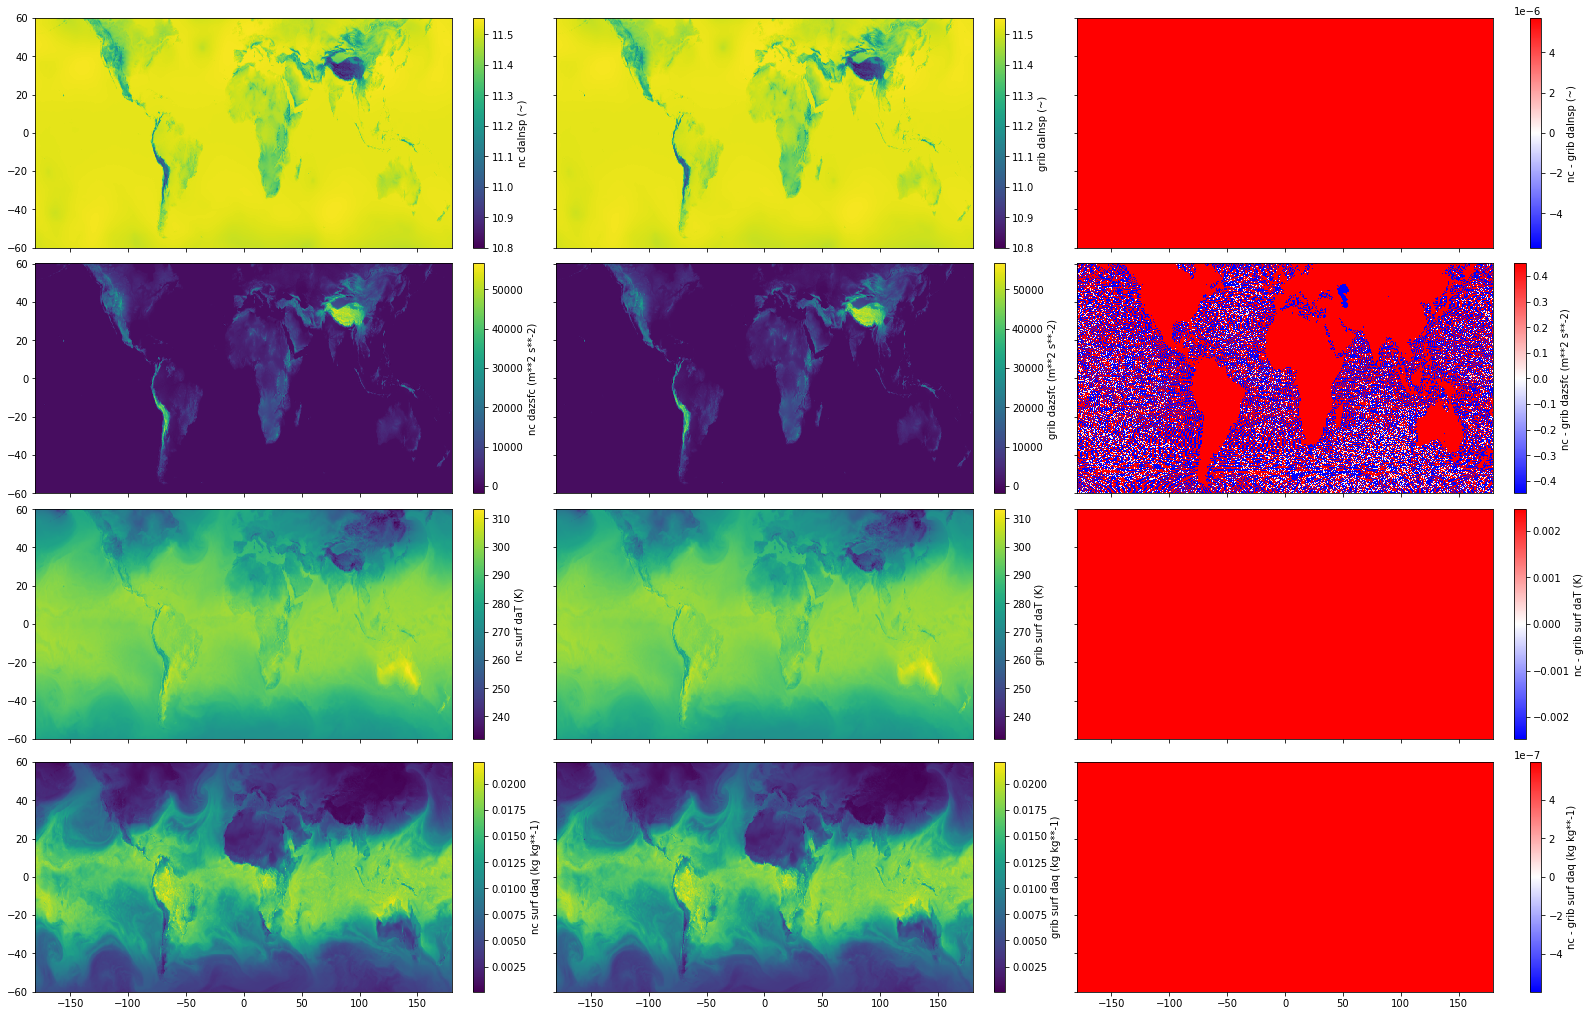

In [65]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, layout='constrained')
fig.set_size_inches(22, 14)

for axrow, var in zip(axes, ['dalnsp', 'dazsfc', 'daT', 'daq']):
    ax0 = axrow[0]
    ax1 = axrow[1]
    ax2 = axrow[2]

    da1 = getattr(nc_comp_alt, var)
    da2 = getattr(grib_comp_alt, var)
    if var in ['daT', 'daq']:
        da1 = da1[-1]
        da2 = da2[-1]
        var = 'surf ' + var

    units = da2.units
    
    im = ax0.pcolormesh(da1.longitude.values, da1.latitude.values, da1.values)
    plt.colorbar(im, ax=ax0, label=f'nc {var} ({units})')
    im = ax1.pcolormesh(da2.longitude.values, da2.latitude.values, da2.values)
    plt.colorbar(im, ax=ax1, label=f'grib {var} ({units})')

    diff = da1.values - da2.values
    absmax = np.abs(diff).max()
    im = ax2.pcolormesh(da2.longitude.values, da2.latitude.values, da2.values, vmin=-absmax, vmax=absmax, cmap='bwr')
    plt.colorbar(im, ax=ax2, label=f'nc - grib {var} ({units})')



### Interpretation of difference fields

Oh that's why. There's a systematic different of around 0.4 m2 s-2 over land for z sfc. 

### Compare altitudes at different heights

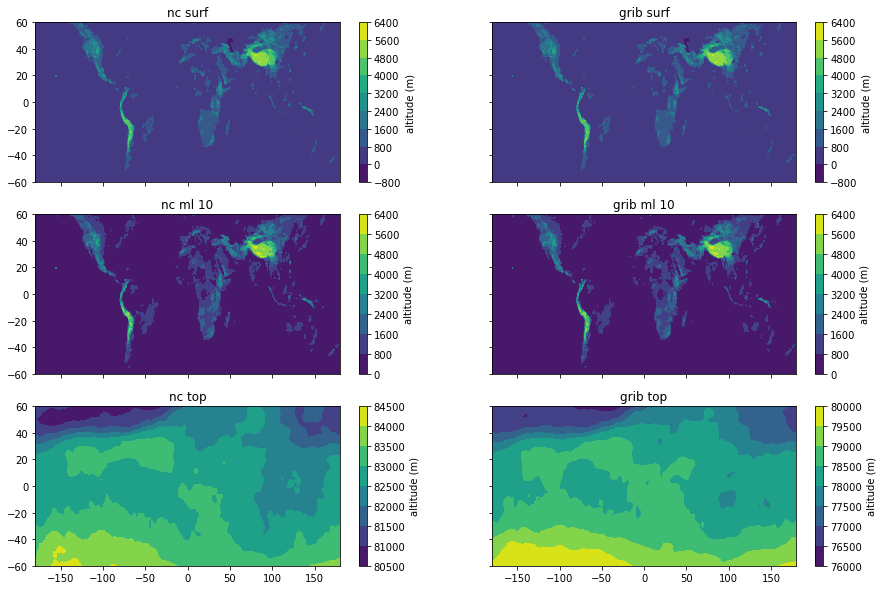

In [19]:
fig, axes = plt.subplots(3, 2, sharex=True, sharey=True)
fig.set_size_inches(15, 10)

axes[0, 0].set_title('nc surf')
da = nc_comp_alt.dalnsp
im = axes[0, 0].contourf(da.longitude.values, da.latitude.values, alt1[-1])
plt.colorbar(im, ax=axes[0, 0], label='altitude (m)')

axes[1, 0].set_title('nc ml 10')
im = axes[1, 0].contourf(da.longitude.values, da.latitude.values, alt1[-10])
plt.colorbar(im, ax=axes[1, 0], label='altitude (m)')

axes[2, 0].set_title('nc top')
im = axes[2, 0].contourf(da.longitude.values, da.latitude.values, alt1[0])
plt.colorbar(im, ax=axes[2, 0], label='altitude (m)')

axes[0, 1].set_title('grib surf')
im = axes[0, 1].contourf(da.longitude.values, da.latitude.values, alt2[-1])
plt.colorbar(im, ax=axes[0, 1], label='altitude (m)')

axes[1, 1].set_title('grib ml 10')
im = axes[1, 1].contourf(da.longitude.values, da.latitude.values, alt2[-10])
plt.colorbar(im, ax=axes[1, 1], label='altitude (m)')

axes[2, 1].set_title('grib top')
im = axes[2, 1].contourf(da.longitude.values, da.latitude.values, alt2[0])
plt.colorbar(im, ax=axes[2, 1], label='altitude (m)')



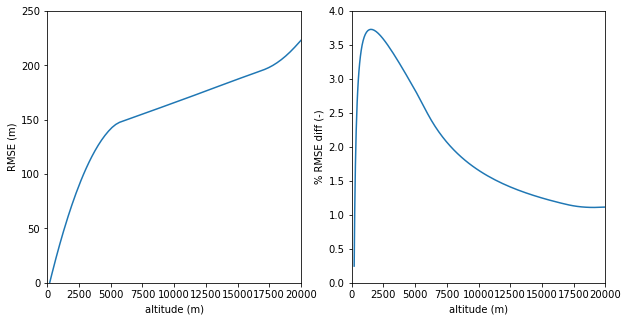

In [27]:

rmses = np.zeros(alt1.shape[0])
levels = nc_comp_alt.daT.level.values
for lev in levels:
    lev_idx = lev - 1
    rmses[lev_idx] = rmse(alt1[lev_idx], alt2[lev_idx])

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(alt2.mean(axis=(1, 2)), rmses)
plt.xlim((0, 20000))
plt.ylim((0, 250))
plt.xlabel('altitude (m)')
plt.ylabel('RMSE (m)')

plt.subplot(122)
plt.plot(alt2.mean(axis=(1, 2)), rmses / alt2.mean(axis=(1, 2)) * 100)
plt.xlim((0, 20000))
plt.ylim((0, 4))
plt.xlabel('altitude (m)')
plt.ylabel('% RMSE diff (-)')

plt.show()


So there is a small error that grows to about 150 m RMSE by 5000 m, then grows more slowly to 220 m by 20000 m. Relative error peaks at ~2000 m at around 3.7%.